<a href="https://colab.research.google.com/github/Jillian-T/ScoreMatchingSDE/blob/main/MNIST_Gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Animation Generation
## 1. Task Description
Assume that we have a number sequence: ["\<g\>", "0", "1", "2", ..., "9"],

"\<g\>" represents gaussian noise image

In this notebook we construct a diffusion pipeline from scratch

if the pipeline receive a sequence such like above, it can generate an animation showing a gaussian noise image transit to a "0" image gradually(\<g\> -->0 ), then "0"-->"1", "1"-->"2, ......, finally to "9"

## 2. Inplementation
### 2.1 Brownian Bridge
We assume a number to number stage is a diffusion process from image A($X_0$) to image B($X_T$) during timesteps=\[0, T \), and this is a stochastic process,

This process can be described as the following stochastic differential equations(SDE): $$X_{t+1} = X_{t} + \frac{X_T-X_t}{T-t}dt + \beta(t)$$

where $t$ represents current timestep, $X_t$ represents the image at time $t$, $\beta(t)$ represents the noise function

To simplify implementation, we set $\beta(t)$ is a noise obey $N(0,1)$, which can be got easily by torch.randn()

We can simulate this stochastic process by training a neural network model $$\theta(X_t, t, label)$$

to fit the drift function $$\frac{X_T-X_t}{T-t}$$

where label is $X_T$'s label

### 2.2 Requirement:
* pytorch
* datasets
* diffusers
* matplotlib
* imageio

In [ ]:
!pip install datasets
!pip install diffusers[training]
!pip install imageio

### 2.3 Data preprocess
The mnist data we use is from huggingface datasets:https://huggingface.co/datasets/mnist

In [ ]:
import torch
from datasets import load_dataset

dataset = load_dataset("mnist", cache_dir='./dataset/')['train'].with_format('torch')

def pad_img(examples):
    """
    Mnist raw data is 28 * 28, which dose not suit for the configurations(32 * 32) of most CV models
    """
    examples['image'] = torch.nn.functional.pad(examples['image'], (2,2,2,2))
    return examples

dataset = dataset.map(pad_img)

"""
Normalize data before construct diffusion bridge
"""
images = dataset['image'].float()
train_mean, train_std = 25.5094, 70.1804 #images.mean(), images.std()

def norm_img(examples):
    examples['norm_img'] = (examples['image'] - train_mean) / train_std
    return examples

dataset = dataset.map(norm_img)

### 2.4 Construct Pipeline

In [ ]:
from typing import Optional
from dataclasses import dataclass

from diffusers import DiffusionPipeline, UNet2DModel, ModelMixin

from diffusers.configuration_utils import ConfigMixin, FrozenDict, register_to_config

from diffusers.utils import BaseOutput
from diffusers.schedulers.scheduling_utils import SchedulerMixin

A normal diffusion pipeline has two necessary components:
* diffusion scheduler
* diffusion model

In [ ]:
@dataclass
class BrownianBridgeSchedulerOutput(BaseOutput):
    """
    Output class for the scheduler's `step` function output

    Args:
        next_sample (`torch.FloatTensor` of shape `(batch_size, num_channels, height, width)` for images):
            Computed sample `(x_{t+1})` of next timestep.
            `next_sample` should be used as model input in the diffusion process.
        pred_final_sample (`torch.FloatTensor` of shape `(batch_size, num_channels, height, width)` for images):
            The predicted final sample `(x_{T})` based on the output from the current timestep.
            `pred_final_sample` can be used to preview progress or for guidance.
    """
    next_sample: torch.FloatTensor
    pred_final_sample: Optional[torch.FloatTensor] = None

class BrownianBridgeScheduler(SchedulerMixin, ConfigMixin):
    """
    `BrownianBridgeScheduler` is a simple implementation of Brownian bridge diffusion process
    Most code references DDPMScheduler: https://github.com/huggingface/diffusers/blob/v0.21.0/src/diffusers/schedulers/scheduling_ddpm.py
    """

    @register_to_config
    def __init__(self, num_train_timesteps: int = 1000):
        super().__init__()
        self.timesteps = torch.arange(0, num_train_timesteps)
        self.dt = 1 / num_train_timesteps

    def step(self, model_output, sample, return_dict: bool = True):
        next_sample = sample + model_output * self.dt + (self.dt ** 0.5) * torch.randn_like(sample)

        if not return_dict:
            return (next_sample,)

        return BrownianBridgeSchedulerOutput(next_sample=next_sample)

    def add_drifts(
        self,
        original_samples: torch.FloatTensor,
        target_samples: torch.FloatTensor,
        timesteps: torch.IntTensor
    ):
        bridge = [original_samples.unsqueeze(0)]
        diffusions = []
        for i in self.timesteps:
            drifts = (target_samples.unsqueeze(0) - bridge[-1]) / (1 - i*self.dt)
            diffusions.append(drifts)
            next_sample = bridge[-1] + drifts * self.dt + (self.dt ** 0.5) * torch.randn_like(bridge[-1])
            bridge.append(next_sample)
        bridge = torch.cat(bridge, dim=0)
        diffusions = torch.cat(diffusions, dim=0)

        sample_t, drift_t = [], []
        for i, t in enumerate(timesteps):
            sample_t.append(bridge[t][i].unsqueeze(0))
            drift_t.append(diffusions[t][i].unsqueeze(0))

        sample_t = torch.cat(sample_t, dim=0)
        drift_t = torch.cat(drift_t, dim=0)

        return sample_t, drift_t

    def __len__(self):
        return self.config.num_train_timesteps


class LabelEncoder(ModelMixin, ConfigMixin):
    config_name = 'LabelEncoder'
    @register_to_config
    def __init__(self, num_embeddings: int=10, embedding_dim: int=1024):
        super().__init__()
        self.label_embedding = torch.nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim)

    def forward(self, input):
        return self.label_embedding(input)

In [ ]:
@dataclass
class MnistSeqPipelineOutput(BaseOutput):
    frames: [torch.Tensor]

class MnistSeqPipeline(DiffusionPipeline):
    @register_to_config
    def __init__(self, label_encoder: LabelEncoder, unet: UNet2DModel, scheduler: BrownianBridgeScheduler):
        super().__init__()
        new_config = dict(scheduler.config)
        scheduler._internal_dict = FrozenDict(new_config)

        self.register_modules(
            label_encoder=label_encoder,
            unet=unet,
            scheduler=scheduler
        )
        self.unet_config = FrozenDict(self.unet.config)

    @torch.no_grad()
    def __call__(
        self,
        label: int,
        batch_size: int = 1,
        start_frame: torch.FloatTensor = None
    ):
        if start_frame is None:
            frame_size = (
                batch_size,
                self.unet_config.in_channels - 1,
                self.unet_config.sample_size,
                self.unet_config.sample_size
            )
            start_frame = torch.randn(size=frame_size)
        else:
            frame_size = start_frame.size()

        l = self.label_encoder(torch.full(size=(frame_size[0],), fill_value=label, dtype=torch.long).to(self.unet.device))
        l = l.view(size=frame_size)
        frames = [start_frame]

        with self.progress_bar(total=len(self.scheduler) - 1) as progress_bar:
            progress_bar.set_description(f'label={label}')
            for t in range(len(self.scheduler)-1):
                sample = torch.cat([frames[-1].to(self.unet.device), l], dim=1)
                model_output = self.unet(sample, t).sample.detach().cpu()
                next_sample = self.scheduler.step(model_output, frames[-1]).next_sample
                frames.append(next_sample.detach().cpu())
                progress_bar.update()

        return MnistSeqPipelineOutput(frames=frames)

## 3. Training

In [ ]:
@dataclass
class LabelEncoderConfig:
    num_embeddings = 10
    embedding_dim = 1024

@dataclass
class TrainingConfig:
    image_size = 32
    num_train_timesteps = 1000
    train_batch_size = 256
    eval_batch_size = 9
    num_epochs = 5        # more than 20 will be better, we set a small training num_epochs to use free colab GPU quota here
    eval_epochs = 5
    mask_rate = 0.1
    gradient_accumulation_steps = 1
    learning_rate = 2e-4
    lr_warmup_steps = 2000
    save_image_epochs = 10
    save_model_epochs = 10
    mixed_precision = 'no'
    output_dir = './MNIST_CONDI_SEQ'
    push_to_hub = False
    overwrite_output_dir = True
    seed = 3407
    labelencoder_config = LabelEncoderConfig()

config = TrainingConfig()

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    dataset=dataset,
    batch_size=config.train_batch_size,
    shuffle=True
)
len(train_dataloader)

235

### 3.1 Initiate diffusion model
You can add more blocks and block_out_channels(>=128) to improve performance

In [ ]:
model = UNet2DModel(
    sample_size=config.image_size,
    in_channels=2,
    out_channels=1,
    layers_per_block=2,
    dropout=0.1,
    block_out_channels=(32, 64, 64),
    down_block_types=(
        "AttnDownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "AttnUpBlock2D",
      ),
)

label_encoder = LabelEncoder(config.labelencoder_config.num_embeddings, config.labelencoder_config.embedding_dim)

In [ ]:
scheduler = BrownianBridgeScheduler(config.num_train_timesteps)

In [ ]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=1e-5)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=config.num_epochs * len(train_dataloader)
)

### 3.2 Evaluate function
Here we both generate a gif animation and a sequence-stage long image

In [ ]:
import os
import io
import imageio.v2 as imageio

import random

from tqdm.auto import tqdm
from matplotlib import pyplot as plt


def generate_gif(config, frames, path, rows, cols):
    progress_bar = tqdm(total=len(frames), desc='Generating animation......')
    frame_list = []
    for step, frame in enumerate(frames):
        f = frame.squeeze().view(rows, cols, config.image_size, config.image_size)
        f = torch.cat([torch.cat([f[i, j] for j in range(cols)], dim=1) for i in range(rows)], dim=0)
        plt.title(f'step-{step:04d}')
        buffer = io.BytesIO()
        plt.imsave(buffer, f)

        buffer.seek(0)
        frame_list.append(imageio.imread(buffer))
        progress_bar.update()
    imageio.mimsave(path, frame_list, duration=1)



def generate_stages(config, frames, path, rows, cols, title=''):
    stages_list = [frames[i] for i in range(0, len(frames), config.num_train_timesteps-1)]
    _, axs = plt.subplots(1, len(stages_list), figsize=(15 * len(stages_list), 15))

    for i, stage in enumerate(stages_list):
        s = stage.squeeze().view(rows, cols, config.image_size, config.image_size)
        s = torch.cat([torch.cat([s[i, j] for j in range(cols)], dim=1) for i in range(rows)], dim=0)
        axs[i].imshow(s)
        axs[i].set_title(title + f'-stage-{i}')
    plt.savefig(path)
    plt.clf()


def evaluate(config, epoch, pipeline):
    test_dir = os.path.join(config.output_dir, 'eval')
    os.makedirs(test_dir, exist_ok=True)
    rows = int(config.eval_batch_size ** 0.5)
    cols = int(config.eval_batch_size / rows)

    eval_seq = [i for i in range(10)]
    random.shuffle(eval_seq)
    eval_seq = eval_seq[:5]

    frames = []
    for label in eval_seq:
        if len(frames) > 0:
            f = pipeline(label, batch_size=config.eval_batch_size, start_frame=frames[-1]).frames
        else:
            f = pipeline(label, batch_size=config.eval_batch_size).frames
        frames += f
    generate_stages(config, frames, f"{test_dir}/epoch-{epoch:04d}.png", rows, cols, title='seq='+str(eval_seq))
    generate_gif(config, frames, f"{test_dir}/{epoch:04d}-seq="+str(eval_seq)+".gif", rows, cols)

### 3.3 Training Loop

In [ ]:
import torch.nn.functional as F

from accelerate import Accelerator
from pathlib import Path

def train_loop(config, model, label_encoder, scheduler, optimizer, train_dataloader, lr_scheduler):
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        project_dir=os.path.join(config.output_dir, 'logs')
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
    accelerator.init_trackers('train_mnist_seq')

    model, label_encoder, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, label_encoder, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f'Epoch: {epoch}')

        for step, batch in enumerate(train_dataloader):
            end_images = batch['norm_img'].unsqueeze(1)
            start_images = torch.flip(end_images, dims=[0])
            mask_index = torch.randperm(len(start_images))[:int(len(start_images)*config.mask_rate)]
            start_images[mask_index] = torch.randn_like(start_images[mask_index])

            labels = label_encoder(batch['label'])
            timesteps = torch.randint(0, len(scheduler), (len(labels),)).to(start_images.device)

            drifted_images, true_drifts = scheduler.add_drifts(start_images, end_images, timesteps)

            labels = labels.view(size=drifted_images.size())
            sample = torch.cat([drifted_images, labels], dim=1)

            with accelerator.accumulate(model):
                drift_pred = model(sample, timesteps).sample
                loss = F.mse_loss(drift_pred, true_drifts)

            accelerator.backward(loss)

            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad()
            lr_scheduler.step()

            progress_bar.update(1)
            logs = {
                'loss': loss.detach().item(),
                'lr': lr_scheduler.get_last_lr()[0],
                'step': global_step
            }
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)

            global_step += 1

        if accelerator.is_main_process:
            pipeline = MnistSeqPipeline(
                label_encoder=label_encoder,
                unet=accelerator.unwrap_model(model),
                scheduler=scheduler
            )
            if (epoch + 1) % config.eval_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(config.output_dir)

Launching training on one GPU.


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

Generating animation......:   0%|          | 0/5000 [00:00<?, ?it/s]

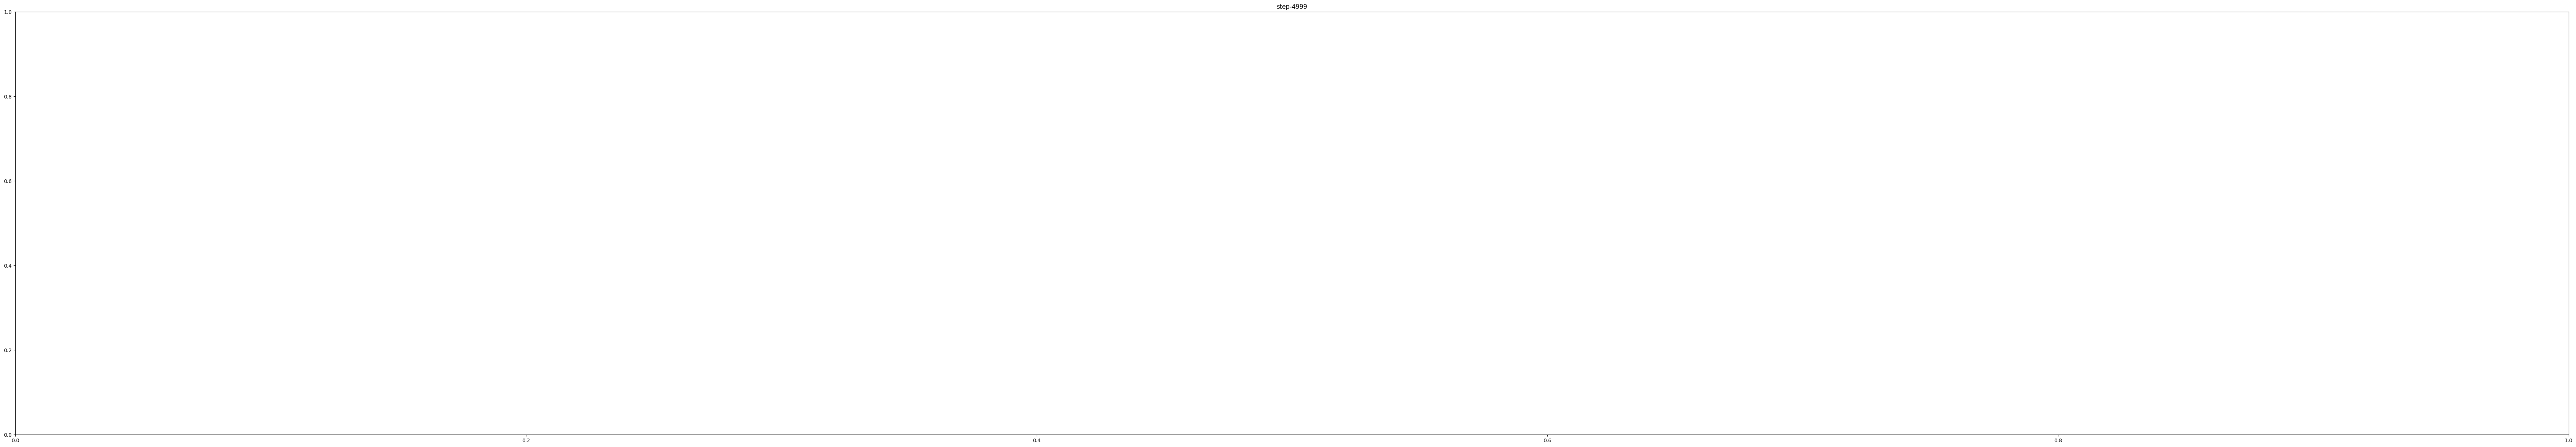

In [ ]:
from accelerate import notebook_launcher

args = (config, model, label_encoder, scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

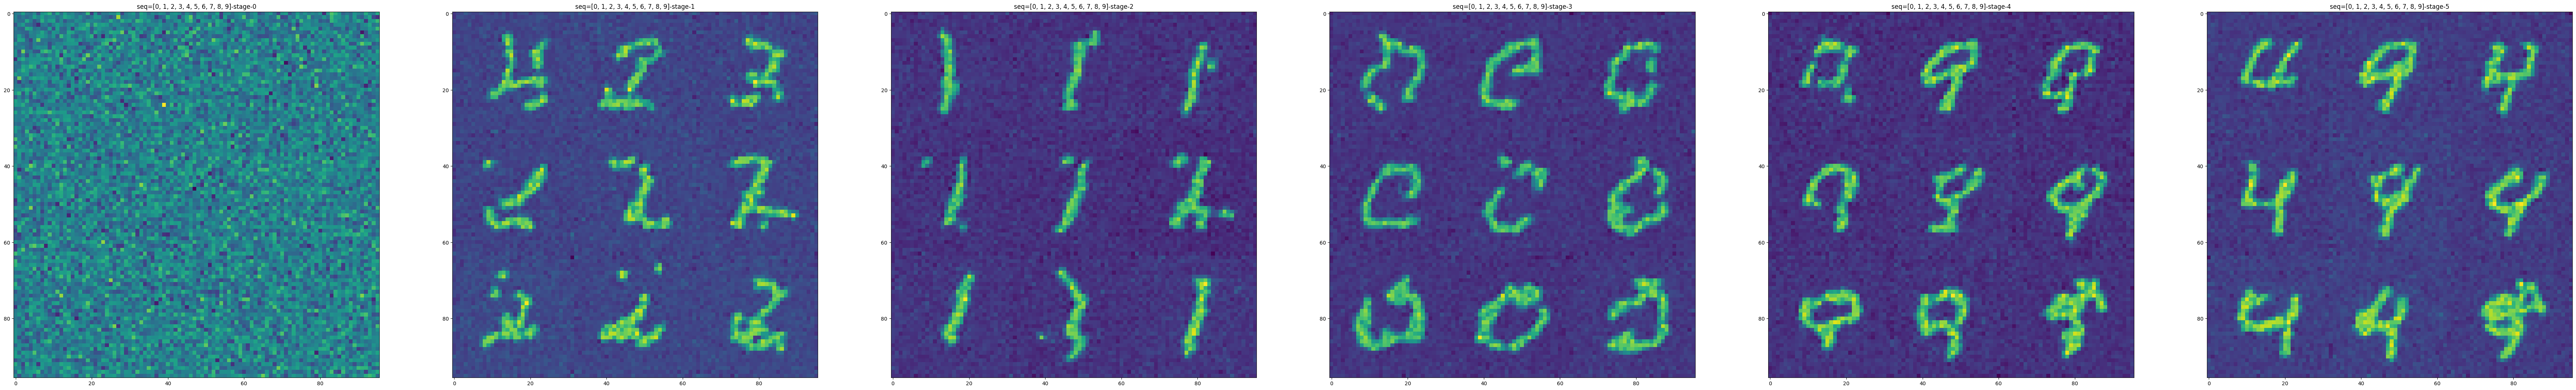

In [ ]:
pipeline = MnistSeqPipeline(
    label_encoder=label_encoder,
    unet=model,
    scheduler=scheduler
)

rows = int(config.eval_batch_size ** 0.5)
cols = int(config.eval_batch_size / rows)

eval_seq = [i for i in range(10)]
random.shuffle(eval_seq)
eval_seq = eval_seq[:5]
title='seq='+str(eval_seq)

frames = []
for label in eval_seq:
    if len(frames) > 0:
        f = pipeline(label, batch_size=config.eval_batch_size, start_frame=frames[-1]).frames
    else:
        f = pipeline(label, batch_size=config.eval_batch_size).frames
    frames += f

stages_list = [frames[i] for i in range(0, len(frames), config.num_train_timesteps-1)]
_, axs = plt.subplots(1, len(stages_list), figsize=(15 * len(stages_list), 15))

for i, stage in enumerate(stages_list):
    s = stage.squeeze().view(rows, cols, config.image_size, config.image_size)
    s = torch.cat([torch.cat([s[i, j] for j in range(cols)], dim=1) for i in range(rows)], dim=0)
    axs[i].imshow(s)
    axs[i].set_title(title + f'-stage-{i}')